In [191]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from prepare import *
from catboost import CatBoostRegressor, Pool
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from metrics import *
from trasnformer import *

warnings.simplefilter("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set(style="darkgrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [192]:
def drop_colums_2(data):
    if "Sales" in data:
        data = data.drop(columns=["Sales"])

    return data.drop(columns=["Max price", "Min price", "Final price", "Color", "Category", "Basic Sale Price", "Days in stock", "Basic Sale", "Base price", "full_category"])

In [193]:
def prepare_data_2(data):
    data["Comments"] = data["Comments"] ** (1/2)
    data["Days with sales"] = data["Days with sales"] ** 0.5

    data["Discount"] = data["Max price"] - data["Min price"]

    # consider rating of 3 as zero (very average stuff) and below as negative
    data['Rating'] = data['Rating'].str.replace(',', '.').astype(float) - 2.5

    # fill average price
    data['Average price'] = data.apply(lambda x : averagePrice(x), axis=1).astype(float)

    # fill sections
    section = data['full_category'].str.split('/').apply(lambda x: x[0])
    sub_section = data['full_category'].str.split('/').apply(lambda x: x[1])
    extra_section = data['full_category'].str.split('/').apply(lambda x:  x[len(x) - 1])

    #data["Section"] = section
    #data["SubSection"] = sub_section
    data["ExtraSection"] = extra_section

    data = section_relative_price(data)

    #data["Average price"] = np.mean([data["Base price"], data["Basic Sale Price"], data["Average price"]], axis=0)

    data.fillna('Nan', inplace=True)

    return drop_colums_2(data)

In [194]:
def evaluate(model, X, y):
    preds = model.predict(X)

    res = np.clip(invert(preds), 0 , 8000)

    print("SMAPE: " + str(smape(res, invert(y))))

In [195]:
data = pd.read_csv("../data/train.csv")

In [196]:
#reg = fit_regressor(data)

y = np.log1p(data["Sales"])

X = np.array([(data["Days with sales"] ** 0.5).values, (data["Comments"] ** 0.5).values])
X = X.T

regressor = LinearRegression().fit(X, y)
print(regressor.score(X, y), regressor.coef_)
res = regressor.predict(X)

data["Approximate"] = res

#make a guess about price
#data["Approximate"] = get_approximation(reg, data)

# prepare data
X = prepare_data_2(data)

transformer = Transformer()

transformer.fit_scaler(X)
X = transformer.scale(X)

0.9145251225891858 [0.91161722 0.06258215]


In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, y_train = remove_outliers_split(X_train, y_train)
X_train.head()

Int64Index([], dtype='int64')


Name         Brand  \
3214           Массажер электрический OVAL/вибромассажер   Juliabeauty   
8203    Воздухонагреватель электрический RedVerg RD-EHC3       RedVerg   
13925  Фреза для маникюра для снятия старого покрытия...       HDFREZA   
18650                 Антимоскитный светильник LED 3 Вт.       Ergolux   
10806  Массажная роликовая подушка с ИК - прогревом и...  Healthy Life   

                                   Seller  Comments  Average price  \
3214   Калашников Андрей Александрович ИП  0.565030      -0.250559   
8203                      ТМК ОПТТОРГ ООО  0.011179      -0.162026   
13925  Мыслицкий Владимир Вячеславович ИП -0.213412      -0.528113   
18650       Энергосистемы и Технологии АО -0.639156      -0.464344   
10806                     КМД-ПАРТНЁР ООО -0.393352      -0.196100   

       Days with sales    Rating  Approximate  Discount  \
3214          2.233792  1.174328     2.117474 -0.344328   
8203          0.587478  1.174328     0.534480 -0.126143   
13925         0.587478  1.174328     0.497859 -0.344328   
18650        -1.233780 -1.243083    -1.222866 -0.344328   
10806         0.054044  1.174328    -0.015137 -0.092417   

                  ExtraSection  Price scale  
3214   Массажеры электрические    -0.687683  
8203            Тепловые пушки    -0.592712  
13925       Фрезы для маникюра    -0.706579  
18650       Лампы от насекомых    -0.309557  
10806  Массажеры электрические    -0.676911

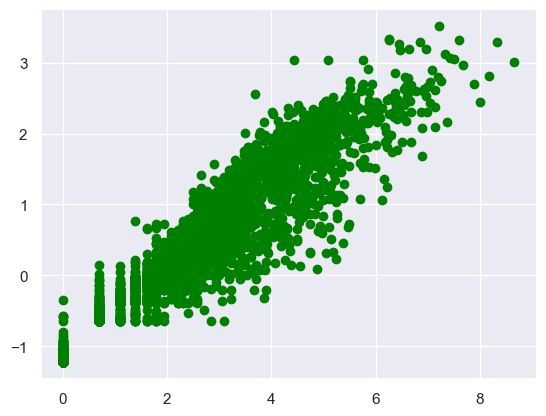

In [198]:
plt.scatter(y_test, X_test["Approximate"], color='green')

In [199]:
cat_features = np.where(X_train.loc[:, X_train.columns.values].dtypes == "object")[0]
# sanity check
X_train.iloc[:, cat_features]

Name         Brand  \
3214           Массажер электрический OVAL/вибромассажер   Juliabeauty   
8203    Воздухонагреватель электрический RedVerg RD-EHC3       RedVerg   
13925  Фреза для маникюра для снятия старого покрытия...       HDFREZA   
18650                 Антимоскитный светильник LED 3 Вт.       Ergolux   
10806  Массажная роликовая подушка с ИК - прогревом и...  Healthy Life   
...                                                  ...           ...   
21575                                Увлажнитель MT-2370         Marta   
5390   Пульт дистанционного управления для приемников...        CADENA   
860                                                 Утюг       Endever   
15795                                      Пульсоксиметр    MEDICINECA   
23654  Пульт Huayu RC1910 для телевизоров Sharp и Tos...         HUAYU   

                                   Seller             ExtraSection  
3214   Калашников Андрей Александрович ИП  Массажеры электрические  
8203                      ТМК ОПТТОРГ ООО           Тепловые пушки  
13925  Мыслицкий Владимир Вячеславович ИП       Фрезы для маникюра  
18650       Энергосистемы и Технологии АО       Лампы от насекомых  
10806                     КМД-ПАРТНЁР ООО  Массажеры электрические  
...                                   ...                      ...  
21575                         ВАЛЕРИЯ ООО         Техника для дома  
5390                    ООО СПУТНИК ТРЕЙД     Пульты телевизионные  
860                          ВЛКГРУПП ООО                    Утюги  
15795    Драганов Александр Алексеевич ИП           Пульсоксиметры  
23654              Дулгер Дарья Сергеевна     Пульты телевизионные  

[20049 rows x 4 columns]

In [201]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
dev_pool = Pool(X_test, y_test, cat_features=cat_features)

org_params = {
    'iterations': 2000,
    'learning_rate': 0.06,
    'eval_metric': 'SMAPE',
    'random_seed': 12,
    'logging_level': 'Silent',
    'use_best_model': True,
    'loss_function': 'MAPE',
    'od_type': 'Iter',
    'od_wait': 1000,
    #'one_hot_max_size': 40,
    'l2_leaf_reg': 100,
    'depth': 8,
    'rsm': 0.6,
    'random_strength': 2,
    'bagging_temperature': 10,
    #'task_type': "GPU",  
    #'devices': '0:1'
}

cat_model = CatBoostRegressor(**org_params)
cat_model.fit(train_pool, eval_set=dev_pool, verbose=0, plot=True, early_stopping_rounds=120)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [162]:
evaluate(cat_model, X_train, y_train)

evaluate(cat_model, X_test, y_test)

SMAPE: 60.59787812868752
SMAPE: 62.574566854861445


In [163]:
cat_model.get_feature_importance(prettified = True)


Feature Id  Importances
0      Approximate    43.408072
1  Days with sales    37.149314
2         Comments     9.952929
3           Rating     2.469068
4           Seller     1.744051
5      Price scale     1.527922
6    Average price     1.523236
7            Brand     1.144890
8         Discount     1.080518
9             Name     0.000000

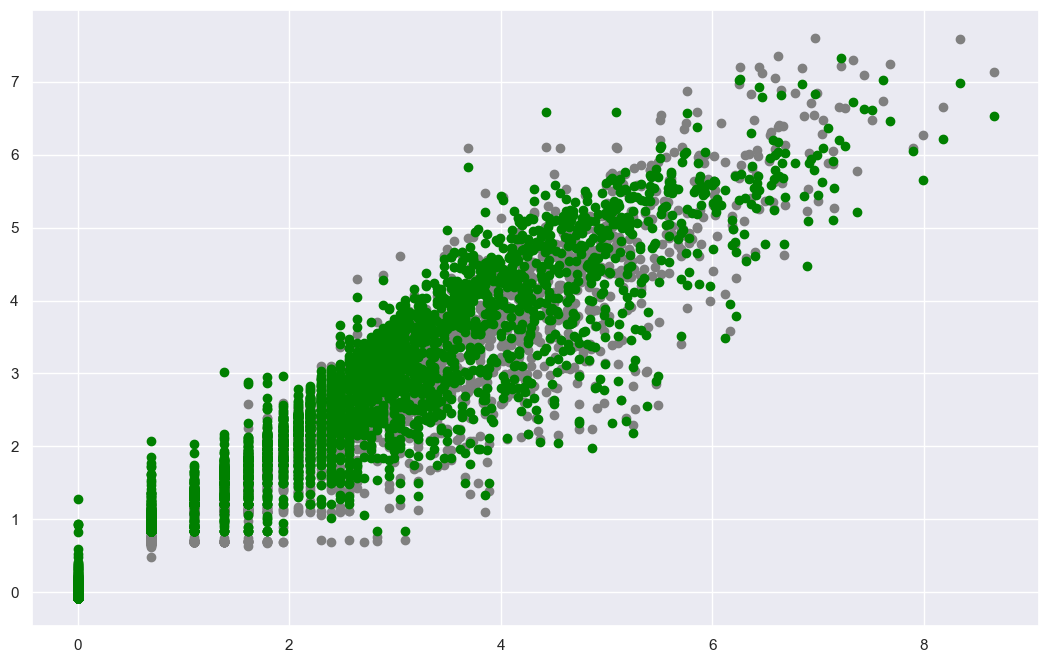

In [164]:
plt.figure(figsize=(13,8))
plt.scatter(y_test, cat_model.predict(X_test), color='gray')
plt.scatter(y_test, X_test["Approximate"], color='green')


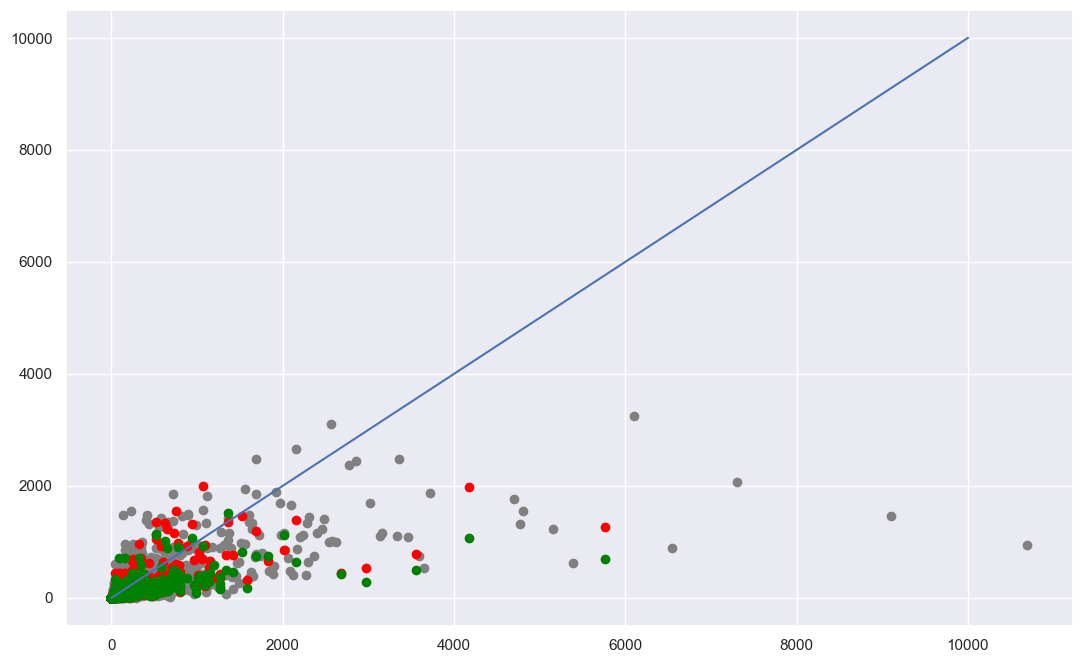

In [165]:
plt.figure(figsize=(13,8))

plt.plot(np.linspace(0, 10000, 2), np.linspace(0, 10000, 2), c = 'b')

plt.scatter(invert(y_train), invert(cat_model.predict(X_train)), color='gray')
plt.scatter(invert(y_test), invert(cat_model.predict(X_test)), color='red')
plt.scatter(invert(y_test), invert(X_test["Approximate"]), color='green')



In [85]:
val_data = pd.read_csv("../data/test.csv")

val_data["Approximate"] = get_approximation(reg, val_data)

val_data = prepare_data(val_data).drop(columns=["Id"])
res = cat_model.predict(val_data)
save_res(res)
val_data.head()

Brand                     Seller  Comments  Average price  Days in stock  \
0  Majava    Бобров Вячеслав Юрьевич  1.414214     448.763441           16.0   
1    Beon                ТЕХПРОМ ООО  2.236068    3105.000000            7.0   
2  NEOLUX        ПКФ НЕВА-ФИЛЬТР ООО  4.358899     555.628205           31.0   
3  CENTEK                ЛИВСИТИ ООО  1.414214     854.666667           31.0   
4   HUAYU  Дулгер Дарья Сергеевна ИП  1.732051     430.666667           31.0   

   Days with sales  Rating  Basic Sale  Approximate  Discount  \
0         3.741657    -3.0        50.0    30.450990      27.0   
1         2.828427     0.0        40.0    16.284344       0.0   
2         4.690416     2.0        30.0    54.197658      40.0   
3         0.000000     1.0        15.0     0.000000       0.0   
4         2.236068     2.0         3.0    10.236084      14.0   

           Section          SubSection                      ExtraSection  \
0  Бытовая техника   Техника для кухни                    Помпы для воды   
1  Бытовая техника   Техника для кухни                         Термопоты   
2  Бытовая техника    Техника для дома             Фильтры для пылесосов   
3  Бытовая техника  Красота и здоровье  Аппараты для маникюра и педикюра   
4  Бытовая техника    Техника для дома              Пульты телевизионные   

   Price scale  
0    -0.487550  
1    -0.441004  
2    -0.383258  
3    -0.469650  
4    -0.421548